In [1]:
from grader_py_scorer import Grader


c:\Users\vasu2\Desktop\UoA\Lecture (class handson)\INFO 698 - Capstone\AUTO-GRADER\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from llms import CallLLM

In [3]:
import os

In [4]:
# Example question
question = "Why is land considered central to the religion and cultural identity of the Dakota people?"

# correct answer a
student_answer_correct_a = "Land is central to Dakota religion and cultural identity because it represents the center of history and culture, where time and place are contained. Sacred spaces, rivers, lakes, rocks, and village sites carry generational and spiritual meaning, linking humans to their origin and the star tribe. Loss of land through trickery, wars, and urban development has been experienced as a loss of cultural identity, making indigenous religion inseparable from geographic spaces. The Dakota view land not just as territory but as memory and sacred power, holding stories, language, and ceremonies that maintain their spiritual and cultural continuity."

# correct answer b
student_answer_correct_b = "Land is central to Dakota religion and cultural identity because it is seen as the place of human origin and the center of the world, where sacred stories, ceremonies, and generational memory connect people to their ancestors and the spiritual realm. Loss of land disrupts this connection, making geography inseparable from their religious and cultural life."

# wrong answer
student_answer_wrong = "Land is not important to the Dakota people’s religion or culture; they primarily focus on reading sacred texts in temples, and their spiritual identity does not depend on geographic locations or natural features."

# unclear answer
student_answer_unclear = "Land matters somehow because it has stories and things tied to people and history, and also rivers and rocks and ceremonies, which all connect in ways that maybe affect memory and identity, though it’s complicated and not exactly like just owning or using the land."

# short answer
student_answer_short = "Land is sacred to the Dakota because it holds their history, stories, and spiritual power."

# gemini answer
student_answer_gemini = '''land is considered central to the religion and cultural identity of the Dakota people for several profound reasons.

The Dakota view MniSotaMakoce (Minnesota) as the place of human origin—the center of the world and the Prime Meridian of their cosmology (religion). The geography is where the earth is conjoined with the star tribe and where humans come from.

Land is essentially memory and history; it contains time and place and is marked by sacred stories and ceremonies. The entirety of the environment—rivers, lakes, rocks, and village sites—all hold generational and spiritual meaning. Therefore, the geographic space is seen as the basis of their sacred power. Because of this intimate spiritual connection, the loss of land is experienced directly as a loss of cultural identity. The Dakota believe the land remembers their stories, even if the people themselves have forgotten.'''


In [5]:
scoring_spec = [
    {
        "label": "Schema Compliance",
        "question": "Does the response follow the specified JSON schema (criteria, scores, comments, etc.)?"
    },
    {
        "label": "Rubric Coverage",
        "question": "Are all rubric criteria evaluated and present in the output?"
    },
    {
        "label": "Logical Alignment",
        "question": "Do the per-criterion scores and comments align logically with the rubric description?"
    },
    {
        "label": "Correct Answer Inclusion",
        "question": "Does the response include a relevant and accurate 'correct_answer' excerpt from the notes?"
    },
    {
        "label": "Note Grounding",
        "question": "Is the evaluation grounded in the reference notes, not external knowledge?"
    },
    {
        "label": "Relevance Enforcement",
        "question": "Does the grader avoid giving credit to off-topic or irrelevant content?"
    },
    {
        "label": "Content Recognition",
        "question": "Does the grader correctly recognize content that directly appears in the notes?"
    },
    {
        "label": "Professional Tone",
        "question": "Is the feedback written in a professional, academic tone?"
    },
    {
        "label": "Constructive Feedback",
        "question": "Are the comments constructive and informative rather than generic?"
    },
    {
        "label": "Balanced Evaluation",
        "question": "Is the feedback balanced — neither too lenient nor excessively harsh?"
    },
    {
        "label": "Note Referencing",
        "question": "Does the feedback clearly reference the content of the notes?"
    },
    {
        "label": "Prompt Fulfillment",
        "question": "Does the grading fulfill all requirements stated in the prompt?"
    },
    {
        "label": "Overall Consistency",
        "question": "Does the overall result seem consistent, fair, and reliable for the given input?"
    }
]


In [6]:
def save_text_to_file(text, filename):
    base_dir = os.path.join("data", "outputs")
    filepath = os.path.join(base_dir, f"{filename}.txt")
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    try:
        with open(filepath, "w", encoding="utf-8") as f:
            f.write(text.strip())
        print(f"Saved successfully at: {filepath}")
    except Exception as e:
        print(f"Failed to save file: {e}")

In [7]:
from withpi import PiClient
import os

def get_piscore(prompt, result, scoring_spec=scoring_spec):
  
    os.environ["WITHPI_API_KEY"] = "sk_d24f2baee781461b85d70c40fe4eedbd"

    pi = PiClient()
    scores = pi.scoring_system.score(
      llm_input= prompt,
      llm_output=result,
      scoring_spec=scoring_spec
    )
    return scores

In [8]:
import pandas as pd
import json
from pathlib import Path

def save_dicts_to_csv(dict_rows, out_filename, append=True):
    """
    Save a list of dicts -> CSV. Creates parent dirs. If append=True will append rows
    to existing file (no header); otherwise overwrite.
    """
    out_path = Path(out_filename)
    if out_path.suffix.lower() != ".csv":
        out_path = out_path.with_suffix(".csv")
    out_path.parent.mkdir(parents=True, exist_ok=True)

    df = pd.DataFrame(dict_rows)
    if append and out_path.exists():
        df.to_csv(out_path, mode="a", header=False, index=False, encoding="utf-8")
    else:
        df.to_csv(out_path, mode="w", header=True, index=False, encoding="utf-8")
    return str(out_path)

In [ ]:
def create_responses_file(temperatures, top_p_values, max_tokens_values, question, student_answer, answer_title, llms):
    for llm in llms:
        for t in temperatures:
            for p in top_p_values:
                for m in max_tokens_values:
                    llms = CallLLM(temperature=t, top_p=p, max_tokens=m)
                    grader = Grader(llms)
                    file_name =  f"scoring/{answer_title}/{llm}/grader_output_temperature-{t}_topPValues-{p}_maxTokens-{m}"
                    context, prompt, result = grader.execute_grader(question, student_answer, llm=llm)
                    print("prompt from here", prompt)
                    text = f"[TITLE]: {answer_title}\n\n[PROMPT]: {prompt}\n\n[RESULT]: {result}"
                    save_text_to_file(text, file_name)
                    scores = get_piscore(prompt, result)
                    row = {
                    "nature_of_answer": answer_title,
                    "question": question,
                    "student_answer": student_answer,
                    "prompt": prompt,
                    "context": context,
                    "response": result,
                    "llm": llm,
                    "temperature": t,
                    "top_p": p,
                    "max_tokens": m
                } | json.loads(str(json.dumps(scores.question_scores))) | {"total_score": scores.total_score}
                    
                    save_dicts_to_csv([row], f"data/outputs/pi_scores/scoring_for_{answer_title}.csv", append=True)
                                    


In [ ]:
temperatures = [0.5, 0.7, 1.0, 1.5]
top_p_values = [0.5, 0.7, 0.9, 1.0]
max_tokens_values = [2000, 4000, 6000, 8000, 10000]
llms = ["gpt, ollama, claude"]

In [16]:
create_responses_file(temperatures, top_p_values, max_tokens_values, question, student_answer_correct_a, "student_answer_correct_a", llms)

Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.5_maxTokens-2000.txt
Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.5_maxTokens-4000.txt
Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.5_maxTokens-6000.txt
Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.5_maxTokens-8000.txt
Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.5_maxTokens-10000.txt
Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.7_maxTokens-2000.txt
Saved successfully at: data\outputs\scoring/student_answer_correct_a/claude/grader_output_temperature-0.5_topPValues-0.7_maxTokens-4000.txt
Saved successfully 

BadRequestError: Error code: 400 - {'type': 'error', 'error': {'type': 'invalid_request_error', 'message': 'temperature: range: 0..1'}, 'request_id': 'req_011CUBpoZJgzP5QQPagTKJh3'}

In [12]:
scoring_spec = [
    # --- Output Quality & Correctness ---
    # {"question": "Is the output in valid JSON format with no syntax errors?"},
    {"question": "Does the response follow the specified JSON schema (criteria, scores, comments, etc.)?"},
    # {"question": "Is the 'final_score' correctly scaled according to the rubric and max_score?"},
    {"question": "Are all rubric criteria evaluated and present in the output?"},
    {"question": "Do the per-criterion scores and comments align logically with the rubric description?"},
    {"question": "Does the response include a relevant and accurate 'correct_answer' excerpt from the notes?"},

    # --- Relevance & Grounding ---
    {"question": "Is the evaluation grounded in the reference notes, not external knowledge?"},
    # {"question": "Are unsupported claims correctly identified and listed?"},
    {"question": "Does the grader avoid giving credit to off-topic or irrelevant content?"},
    {"question": "Does the grader correctly recognize content that directly appears in the notes?"},

    # --- Tone & Feedback Style ---
    {"question": "Is the feedback written in a professional, academic tone?"},
    {"question": "Are the comments constructive and informative rather than generic?"},
    {"question": "Is the feedback balanced — neither too lenient nor excessively harsh?"},
    {"question": "Does the feedback clearly reference the content of the notes?"},

    # # --- Strictness Level Compliance ---
    # {"question": "Does the evaluation reflect the specified strictness level (1–5)?"},
    # {"question": "If strictness is high (≥4), are unsupported or vague answers penalized appropriately?"},
    # {"question": "If strictness is low (≤2), is the grader more lenient toward minor missing details?"},
    # {"question": "Does the strictness behavior match the expected tone in the prompt instructions?"},

    # --- Overall Response Validity ---
    {"question": "Does the grading fulfill all requirements stated in the prompt?"},
    {"question": "Does the overall result seem consistent, fair, and reliable for the given input?"}
]

In [1]:
import pandas as pd
df = pd.read_csv("data/outputs/pi_scores/scoring_forstudent_answer_correct_a.csv")

In [2]:
df.head()

,nature_of_answer,question,student_answer,prompt,context,response,llm,temperature,top_p,max_tokens,...,Logical Alignment,Note Grounding,Note Referencing,Overall Consistency,Professional Tone,Prompt Fulfillment,Relevance Enforcement,Rubric Coverage,Schema Compliance,total_score
0,student_answer_correct_a,Why is land considered central to the religion...,Land is central to Dakota religion and cultura...,\n You are grading a student's answer using...,"Dakota, the land remembers.\n\nMinnesota, incl...","```json\n{\n ""criteria"": [\n {\n ...",gpt,0.5,0.5,2000,...,0.7031,0.4043,0.7070,0.7891,0.9805,0.6758,0.9258,0.7930,0.8047,0.6033
1,student_answer_correct_a,Why is land considered central to the religion...,Land is central to Dakota religion and cultura...,\n You are grading a student's answer using...,"Dakota, the land remembers.\n\nMinnesota, incl...","```json\n{\n ""criteria"": [\n {\n ...",gpt,0.5,0.5,4000,...,0.6406,0.2451,0.7422,0.7656,0.9844,0.6094,0.9219,0.7617,0.8125,0.5626
2,student_answer_correct_a,Why is land considered central to the religion...,Land is central to Dakota religion and cultura...,\n You are grading a student's answer using...,"Dakota, the land remembers.\n\nMinnesota, incl...","```json\n{\n ""criteria"": [\n {\n ...",gpt,0.5,0.5,6000,...,0.6680,0.2266,0.6680,0.7695,0.9805,0.6641,0.9102,0.7734,0.7812,0.5395
3,student_answer_correct_a,Why is land considered central to the religion...,Land is central to Dakota religion and cultura...,\n You are grading a student's answer using...,"Dakota, the land remembers.\n\nMinnesota, incl...","```json\n{\n ""criteria"": [\n {\n ...",gpt,0.5,0.5,8000,...,0.6680,0.2969,0.6992,0.7734,0.9727,0.6406,0.9141,0.7656,0.7734,0.5903
4,student_answer_correct_a,Why is land considered central to the religion...,Land is central to Dakota religion and cultura...,\n You are grading a student's answer using...,"Dakota, the land remembers.\n\nMinnesota, incl...","```json\n{\n ""criteria"": [\n {\n ...",gpt,0.5,0.5,10000,...,0.6562,0.2480,0.6367,0.7734,0.9648,0.6055,0.9141,0.7383,0.7461,0.5422


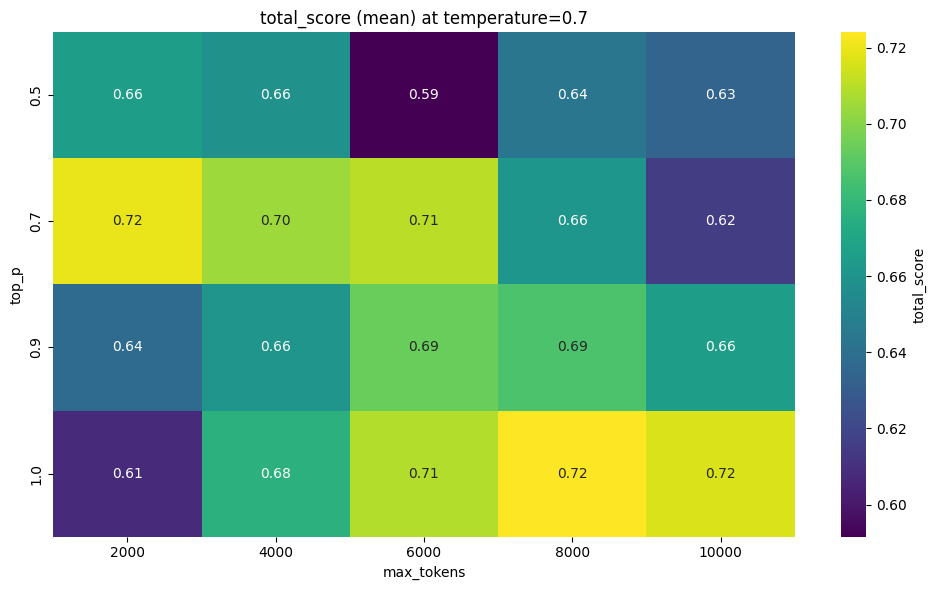

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

csv_path = "data/outputs/pi_scores/scoring_forstudent_answer_correct_a.csv" 
fixed_temperature = 0.7 
value_col = "total_score"
top_p_col = "top_p"
max_tokens_col = "max_tokens"
temp_col = "temperature"

df = pd.read_csv(csv_path)

for c in [temp_col, top_p_col, max_tokens_col, value_col]:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
df_f = df[df[temp_col] == fixed_temperature]
pivot = df_f.pivot_table(index=top_p_col, columns=max_tokens_col, values=value_col, aggfunc="mean")
pivot = pivot.sort_index().reindex(sorted(pivot.columns), axis=1)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="viridis", cbar_kws={"label": value_col})
plt.title(f"{value_col} (mean) at temperature={fixed_temperature}")
plt.xlabel(max_tokens_col)
plt.ylabel(top_p_col)
plt.tight_layout()
plt.show()

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation_scatter(a, b, df):
    correlation = df[a].corr(df[b])
    print(f"Pearson Correlation between Variable_A and Variable_B: {correlation:.2f}")
    plt.figure(figsize=(8, 6)) # Adjust figure size as needed
    sns.scatterplot(x=a, y=b, data=df)
    sns.regplot(x=a, y=b, data=df, scatter=False, color='red')
    plt.title(f'Scatter Plot of {a} vs {b} (Correlation: {correlation:.2f})')
    plt.xlabel(a)
    plt.ylabel(b)
    plt.grid(True)
    plt.show()

In [26]:
df.columns

Index(['nature_of_answer', 'question', 'student_answer', 'prompt', 'context',
       'response', 'llm', 'temperature', 'top_p', 'max_tokens',
       'Balanced Evaluation', 'Constructive Feedback', 'Content Recognition',
       'Correct Answer Inclusion', 'Logical Alignment', 'Note Grounding',
       'Note Referencing', 'Overall Consistency', 'Professional Tone',
       'Prompt Fulfillment', 'Relevance Enforcement', 'Rubric Coverage',
       'Schema Compliance', 'total_score'],
      dtype='object')

In [30]:
df_piscores = df[['Balanced Evaluation', 'Constructive Feedback', 'Content Recognition', 'Correct Answer Inclusion', 'Logical Alignment', 'Note Grounding','Note Referencing', 'Overall Consistency', 'Professional Tone', 'Prompt Fulfillment', 'Relevance Enforcement', 'Rubric Coverage', 'Schema Compliance']]

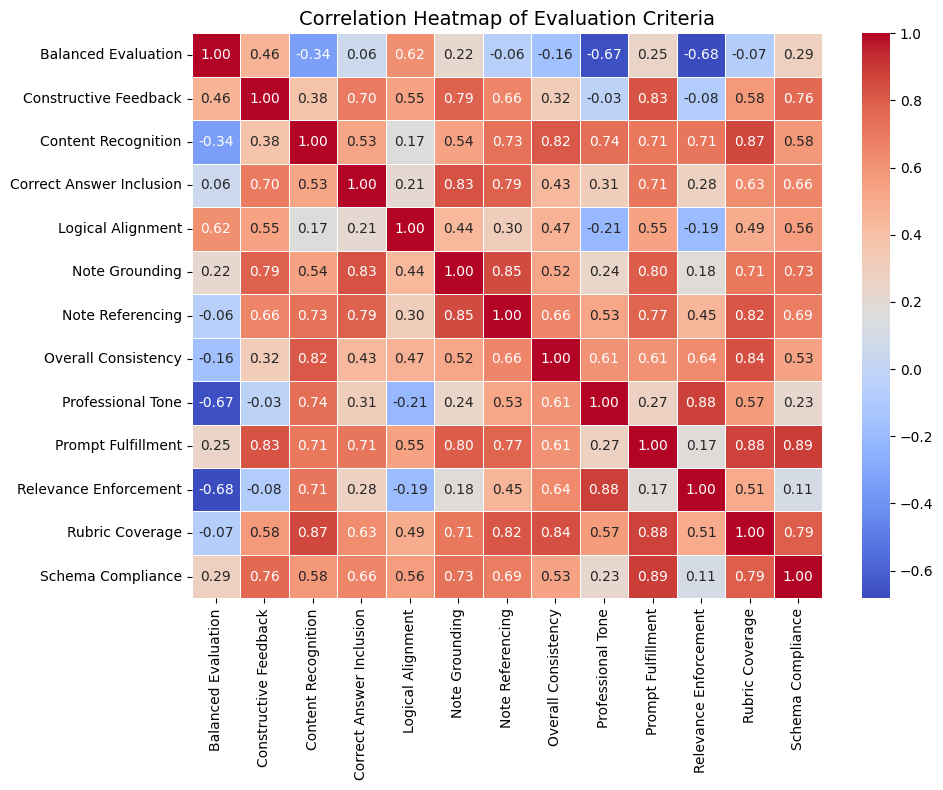

In [33]:
corr = df_piscores.corr(numeric_only=True)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr, 
    annot=True,           # show values in cells
    cmap='coolwarm',      # color palette
    fmt=".2f",            # number format
    linewidths=0.5        # thin lines between cells
)

plt.title("Correlation Heatmap of Evaluation Criteria", fontsize=14)
plt.tight_layout()
plt.show()